# Core steps to start a typical machine learning problem

Welcome to my first post! 

I have been taking almost all of the kaggle courses in the past several weeks, and I have learned quite a lot from them. While I am already familiar with most of the basic machine learning algorithms, there are plenty of useful packages that I haven't been taking advantage of, and there are some good rule of thumbs that I didn't know. The purpose of this notebook is to document useful code sbnippets I learned from these courses, and hopefully they can be reused in my future data science projects!

This is also a good practice for me to learn Markdown and host Jupyter notebooks.

## Example dataset: predicting house prices 

I am going to use the tutorial [housing prices prediction dataset](https://www.kaggle.com/c/home-data-for-ml-course) from Kaggle. We will try to predict the house prices based on some features such as number of rooms and house area. Let's first load the data in:

In [1]:
# load in the dataset
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 

dataset_path = "../datasets/house_prices_prediction/"

X_full = pd.read_csv(os.path.join(dataset_path, 'train.csv'), index_col='Id')
X_test_full = pd.read_csv(os.path.join(dataset_path, 'test.csv'), index_col='Id')
print('Train dataset has {} data points with {} columns'.format(X_full.shape[0], X_full.shape[1]))

# Remove rows with missing y (house price) and separate dataset into X and y
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)
print('\nRemove Rows with missing y')
print('Train dataset now has {} data points with {} columns'.format(X_full.shape[0], X_full.shape[1]))




Train dataset has 1460 data points with 80 columns

Remove Rows with missing y
Train dataset now has 1460 data points with 79 columns


### Data cleaning: deal with missing values

We should always inspect the data first with the *head()* or *describe()* function. Specifically, we should watch out for missing entries, as most ML algorithms except random forest aren't designed to handle them.

We should output the name of the columns with missing entries

In [2]:
# always try to get an idea of the data you are working with!
#print(X_full.head())
#print(X_full.describe())

# look for columns with missing entries
NA_column_names = X_full.isnull().sum().sort_values(ascending=False)
NA_column_names = NA_column_names[NA_column_names > 0]
print('Columns with NA entries: ')
print(NA_column_names)

Columns with NA entries: 
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


There are several columns with missing entries. Columns with few missing entries such as *Electrical* can usually be dropped directly. For the other columns, we should look into the data description to see why there are missing values.

Are they simply not recorded, or are they left blank for obvious reasons? 

How should we deal with these columns?
1. We can simply drop the column
2. We can use an imputer to replace NA values with mean, median etc...
3. We can use an imputer plus adding feature columns to denote the imputed entries

In [3]:
X_full.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

column LotFrontage has 259 NA entries
count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64


<AxesSubplot:>

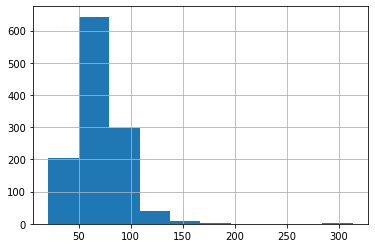

In [4]:
idx = 2
colname = X_full.columns[idx]
print('column {} has {} NA entries'.format(colname, X_full[colname].isna().sum()))
print(X_full[colname].describe())
X_full[colname].hist(bins=10)

In [6]:
# Perform various actions on theses columns with missing entries 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

X = X_full.copy()

y = np.log1p(y) # looks more Gaussian-like

# 1. There are only several houses with MiscFeature, and MiscVal stores there value
#    All possible values are ['Elev', 'Gar2', 'Othr', 'Shed', 'TenC']
#    Most are just 'Shed'
#    I will create a column ShedArea to record MiscVal for Shed, and throw away column MiscFeature and MiscVal
isShed = X.MiscFeature == 'Shed'
X.loc[isShed, 'MiscVal'] = 0.0
X.rename(columns={'MiscVal': 'ShedArea'}, inplace=True)
X.drop(columns=['MiscFeature'], inplace=True)

# 2. Alley: only Grvl or Pave alley
#    use two one-hot columns (GrvlAlley, PaveAlley) here and drop Alley
X['isGrvlAlley'] = pd.Series(X.Alley == 'Grvl', index=X.index, dtype=float)
X['isPavedAlley'] = pd.Series(X.Alley == 'Pave', index=X.index, dtype=float)
X.drop(columns=['Alley'], inplace=True)

# 3. Fence: good/minimum privacy, good/minimum wood
#    column FencePrivacy: [2, 1, 0] for [good/minimum/NA]
#    column FenceWood: [2, 1, 0] for [good/minimum/NA]
X['FencePrivacy'] = X.Fence.map({'GdPrv': 2.0, 'MnPrv': 1.0, 'GdWo': 0.0, 'MnWw': 0.0, np.nan: 0.0})
X['FenceWood'] = X.Fence.map({'GdPrv': 0.0, 'MnPrv': 0.0, 'GdWo': 2.0, 'MnWw': 1.0, np.nan: 0.0})
X.drop(columns=['Fence'], inplace=True)

# 4. LotFrontage: replace with 0 or average?

# 5. Garage columns
#    replace NA entries in GarageYrBlt with the oldest year
X.GarageYrBlt.fillna(1900.00, inplace=True)


# 6. MasVnr columns
#    should change NA entries in MasVnrType to 'None'
#    should change NA entries in MasVnrArea to 0.0

X.MasVnrType.fillna('None', inplace=True)
X.MasVnrArea.fillna(0.0, inplace=True)

# 7. Electrical columns
#    only one missing entry: throw this row away!
y = y[X.Electrical.notna()]
X = X[X.Electrical.notna()]

# 8. CentralAir column:
X.CentralAir = X.CentralAir.map({'N': 0.0, 'Y': 1.0})

# For the rest of the columns, we apply the default pipeline
one_hot_cols = ['MSZoning', 'LotConfig', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
                'Foundation', 'Heating', 'MasVnrType', 'GarageType']
#ordinal_cols = ['Street', 'LotShape', 'LandContour', 'Utilities', 
#                'LandSlope', 'ExterQual', 'ExterCond', 'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 
#                'PavedDrive', 'PoolQC', 'FireplaceQu', 'GarageQual', 'GarageCond', 'GarageFinish', 
#                'BsmtQual', 'BsmtCond', 'BsmtExposure']
too_many_entries_cols = ['Neighborhood', 'Condition1', 'Condition2', 'Exterior1st', 'Exterior2nd', 
                         'SaleType', 'SaleCondition']
X.drop(columns=too_many_entries_cols, inplace=True)

num_cols = X.columns[(X.dtypes == 'float64') | (X.dtypes == 'int64')]

categories_onehot = [
    X[column].unique() for column in X[one_hot_cols]]

for cat in categories_onehot:
    cat[cat == np.nan] = 'missing'  # replace NA entries with 'missing'
    
def cat_proc_ordinal(categories, num_cols):
    """Create preprocessing pipeline for ordinal category variables. takes list-like categories"""
    return make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy='constant',
            fill_value='Missing'),
        OrdinalEncoder(categories=[np.array(categories)] * num_cols, dtype=np.float)
        )

cat_proc_onehot = make_pipeline(
    SimpleImputer(missing_values=np.nan,
                  strategy='constant',
                  fill_value='Missing'),
    OneHotEncoder(dtype=np.float, handle_unknown='ignore')
)

num_proc = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

# deal with ordinal columns separately
preprocessor = make_column_transformer(
    (cat_proc_ordinal(['Grvl', 'Pave'], 1), ['Street']),
    (cat_proc_ordinal(['IR3', 'IR2', 'IR1', 'Reg'], 1), ['LotShape']),
    (cat_proc_ordinal(['Low', 'HLS', 'Bnk', 'Lvl'], 1), ['LandContour']),
    (cat_proc_ordinal(['ELO', 'NoSeWa', 'NoSeWr', 'AllPub'], 1), ['Utilities']),
    (cat_proc_ordinal(['Sev', 'Mod', 'Gtl'], 1), ['LandSlope']),
    (cat_proc_ordinal(['FuseP', 'FuseF', 'FuseA', 'Mix', 'SBrkr'], 1), ['Electrical']),
    (cat_proc_ordinal(['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], 1), ['Functional']),
    (cat_proc_ordinal(['N', 'P', 'Y'], 1), ['PavedDrive']),
    (cat_proc_ordinal(['Missing', 'Unf', 'RFn', 'Fin'], 1), ['GarageFinish']),
    (cat_proc_ordinal(['Missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], 2), ['BsmtFinType1', 'BsmtFinType2']),
    (cat_proc_ordinal(['Po', 'Fa', 'TA', 'Gd', 'Ex'], 4), 
         ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual']),
    (cat_proc_ordinal(['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], 5), 
         ['FireplaceQu', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond']),
    (cat_proc_ordinal(['Missing', 'Fa', 'TA', 'Gd', 'Ex'], 1), ['PoolQC']),
    (cat_proc_ordinal(['Missing', 'No', 'Mn', 'Av', 'Gd'], 1), ['BsmtExposure']),
    (cat_proc_onehot, one_hot_cols),
    (num_proc, num_cols),
    remainder='passthrough')


### Cut dataset into training and validation set and start training



In [7]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

# I will compare a random forest model to a xgboost model
#X_train_transformed = preprocessor.fit_transform(X_train)
#X_valid_transformed = preprocessor.transform(X_valid)
xgb_model = XGBRegressor(n_estimators=700, learning_rate=0.02)
xgb_clf = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6],
                                  'n_estimators': [100, 200, 300],
                                  'learning_rate': [0.01, 0.03, 0.05],
                                  'gamma': np.logspace(-5, 2, 5),
                                  'reg_lambda': np.logspace(-2, 0, 3)}, verbose=1,
                       n_jobs=2, cv=5, scoring='neg_mean_absolute_error')
xgb_clf.fit(preprocessor.fit_transform(X), y)

# TODO: try DART booster

print('MAE trained with xg model: ', xgb_clf.best_score_)
print('best xg model parameters: ', xgb_clf.best_params_)

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestRegressor(random_state=0))])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, y_pred_rf)
print('MAE trained with rf model:', score)

#estimators = [('Random Forest', rf_pipeline),
#              ('Lasso', lasso_pipeline),
#              ('Gradient Boosting', gradient_pipeline)]

#stacking_regressor = StackingRegressor(estimators=estimators,
#                                       final_estimator=RidgeCV())

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 

### Transform categorical features into numerical ones



### Generate submission.csv

In [8]:
# remember to apply np.exp1m to get back normal sale price!